In [1]:
import json
import os
import sys

sys.path.append('/home/luis/CGE/luxgiant-dstream/luxgiant_dstream')

from luxgiant_dstream.prep_ds import PrepDS
from luxgiant_dstream.gwas_fixed import GWASfixed
from luxgiant_dstream.gwas_random import GWASrandom

In [2]:
#params = json.load(open("//home/luis/data/testDownStream/configFiles/parameters.JSON"))
#paths = json.load(open("/home/luis/data/testDownStream/configFiles/paths_local.JSON"))

params = json.load(open("//home/luis/data/LuxGiantimputed/configFiles/parameters.JSON"))
paths = json.load(open("/home/luis/data/LuxGiantimputed/configFiles/paths_local.JSON"))

In [11]:
prep = PrepDS(
    input_path=paths['input_directory'],
    input_name=paths['input_prefix'],
    output_path=paths['output_directory'],
    output_name=paths['output_prefix'],
    config_dict=params,
    dependables_path=paths['dependables_directory'],
)

In [12]:
prep_steps = {
    'ld_prune': prep.exclude_high_ld_hla,
    'pca'     : prep.pca_decomposition
}

for step in prep_steps.keys():
    prep_steps[step]()

PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/luis/data/testDownStream/outputData/preparatory/ds_results_prunning.log.
Options in effect:
  --bfile /home/luis/data/testDownStream/inputData/subset_data_luxgiant
  --chr 1-22
  --exclude /home/luis/data/testDownStream/dependables/high-LD-regions.txt
  --geno 0.1
  --hwe 5e-08
  --indep-pairwise 50 5 0.2
  --maf 0.05
  --make-bed
  --out /home/luis/data/testDownStream/outputData/preparatory/ds_results_prunning
  --range
  --threads 30

Note: --range flag deprecated.  Use e.g. "--extract range <filename>".
63927 MB RAM detected; reserving 31963 MB for main workspace.
23169127 variants loaded from .bim file.
466 people (322 males, 144 females) loaded from .fam.
466 phenotype values loaded from .fam.
--exclude range: 499022 variants excluded.
--exclude range: 22670105 variants remaining.
Using 1 thread (no multithre

In [3]:
gwas_f = GWASfixed(
    input_path = paths['input_directory'],
    input_name = paths['input_prefix'],
    output_path= paths['output_directory'],
    output_name= paths['output_prefix'],
    config_dict= params,
    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
)

Analysis of GWAS data using a fixed model initialized.


In [4]:
gwas_f_steps = {
    'train_model': gwas_f.fixed_model_association_analysis,
    'top_hits'   : gwas_f.get_top_hits,
    'annotate'   : gwas_f.annotate_top_hits,
    'plots'      : gwas_f.plot_drawings
}

for step in gwas_f_steps.keys():
    gwas_f_steps[step]()

In [7]:
gwas_r = GWASrandom(
    input_path = paths['input_directory'],
    input_name = paths['input_prefix'],
    output_path= paths['output_directory'],
    output_name= paths['output_prefix'],
    config_dict= params,
    preps_path = os.path.join(paths['output_directory'], 'preparatory'),
)

*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Nov 15 2022 21:14:25, by GCC 8.5
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 10:24:04 CEST on Fri Sep 13 2024.
Hostname: IKEAB-TS-P3

Options: 
 
--bfile /home/luis/data/testDownStream/outputData/preparatory/ds_results_LDpruned 
--make-grm 
--thread-num 30 
--out /home/luis/data/testDownStream/outputData/gwas_random/ds_results_grm 

The program will be running with up to 30 threads.
Note: GRM is computed using the SNPs on the autosomes.
Reading PLINK FAM file from [/home/luis/data/testDownStream/outputData/preparatory/ds_results_LDpruned.fam]...
466 individuals to be included from FAM file.
466 individuals to be included. 322 males, 144 females, 0 unknown.
Reading PLINK BIM file from [/ho

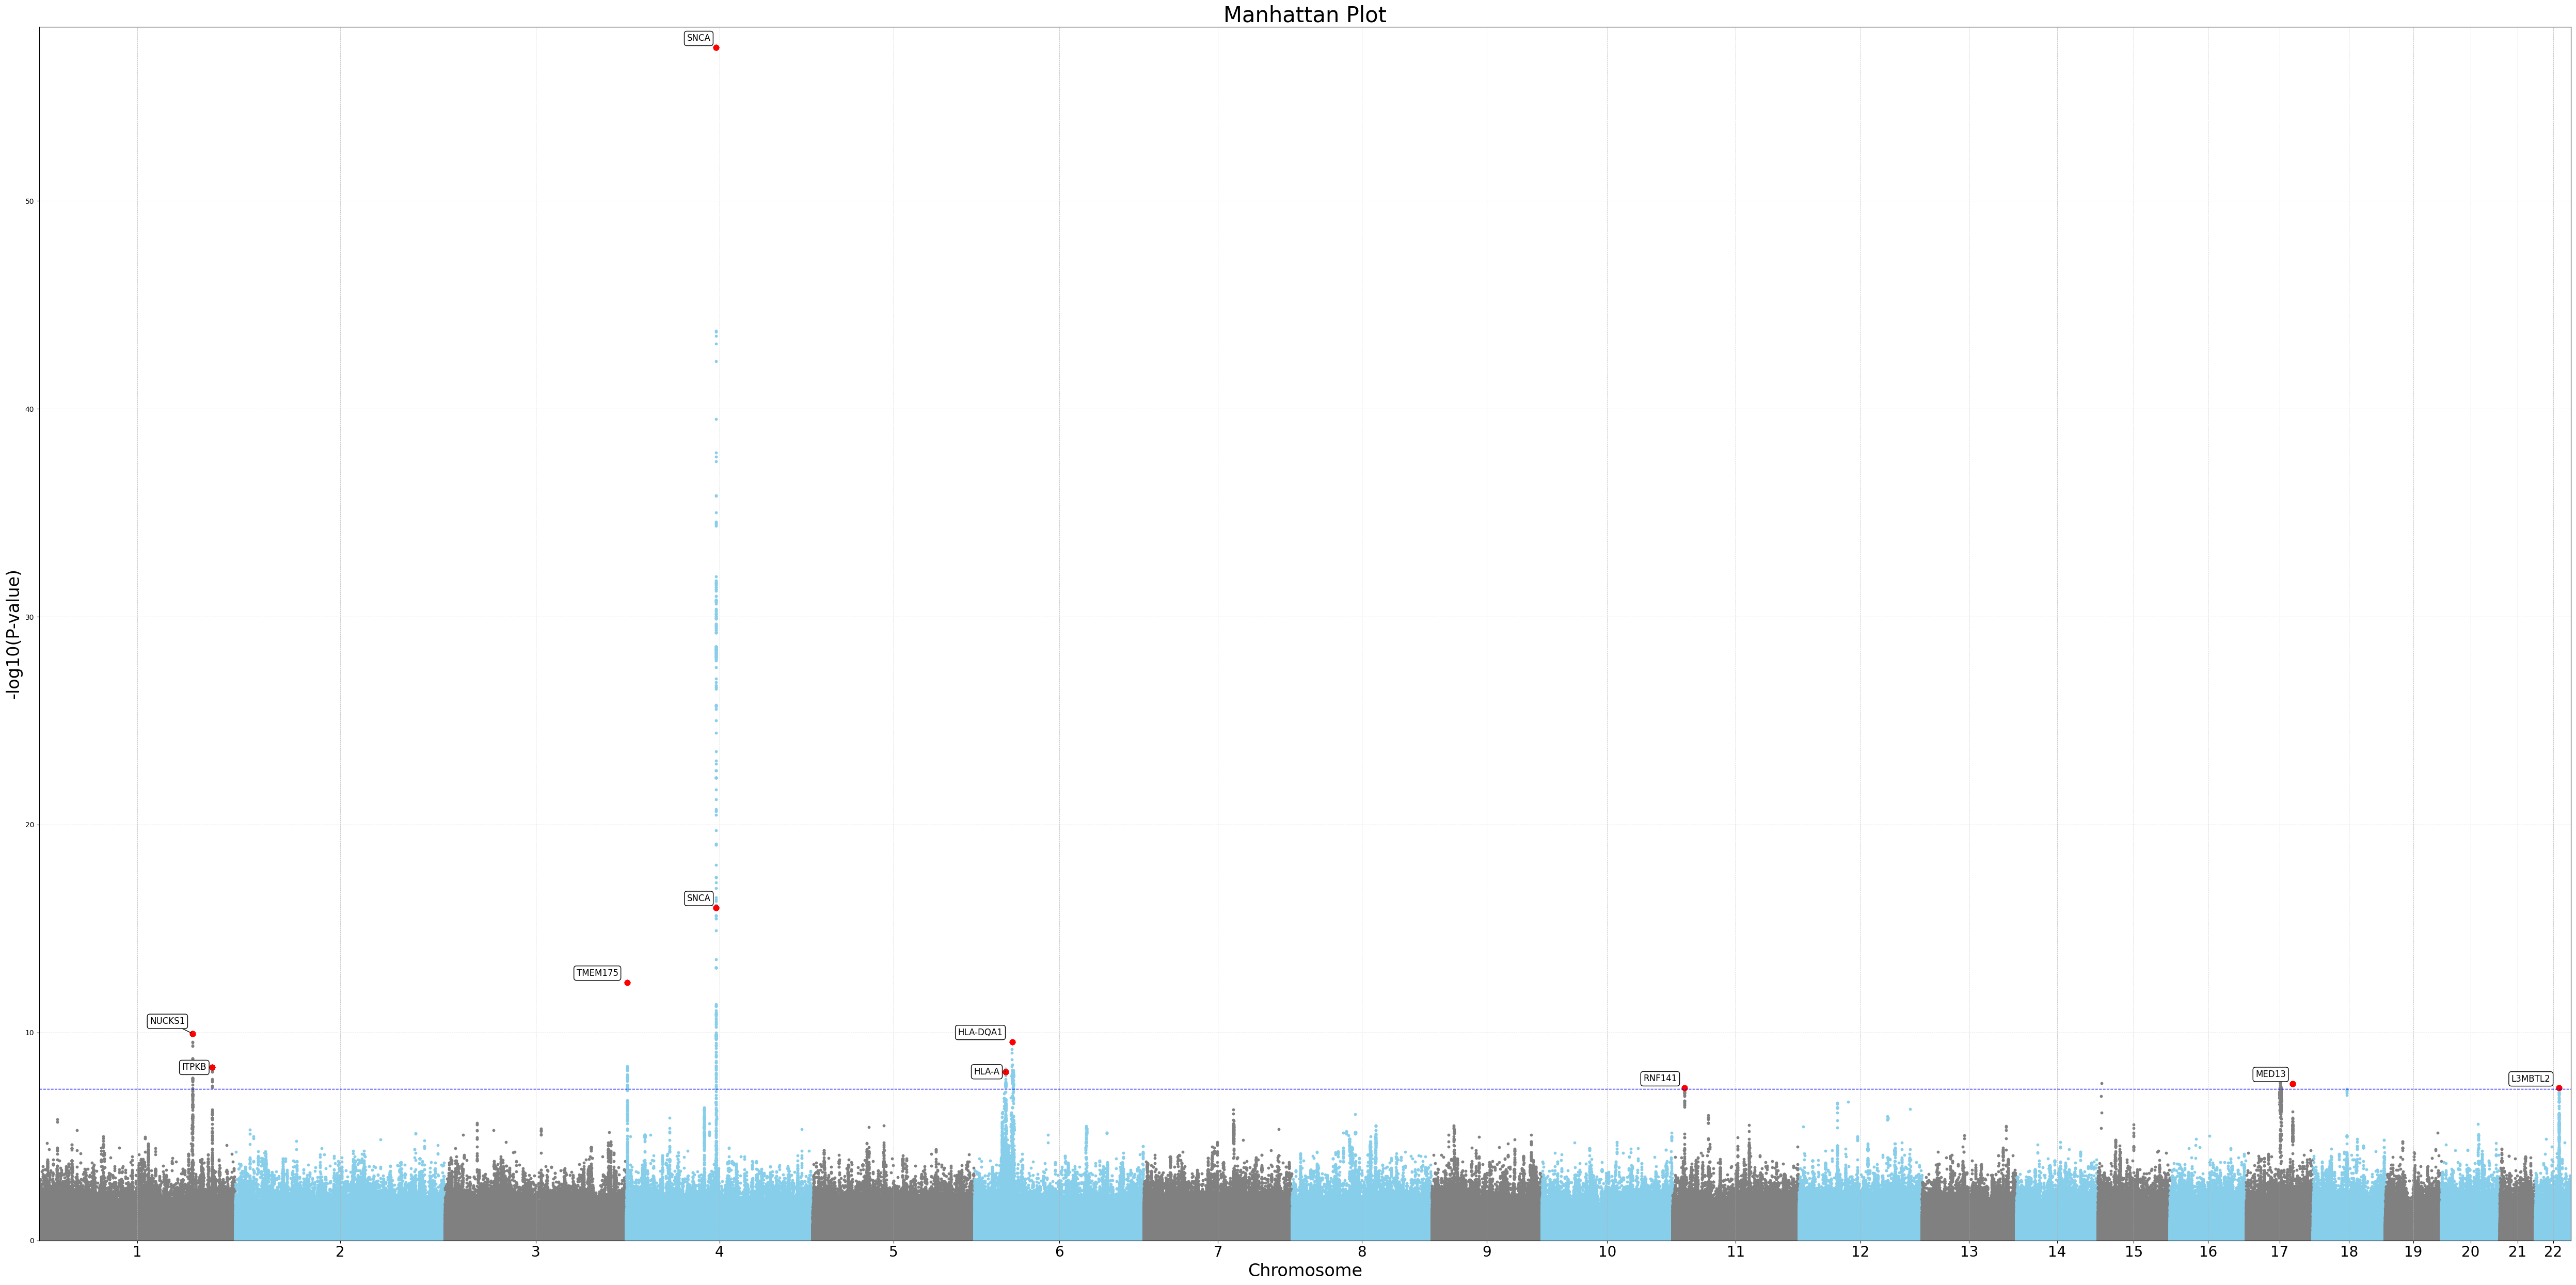

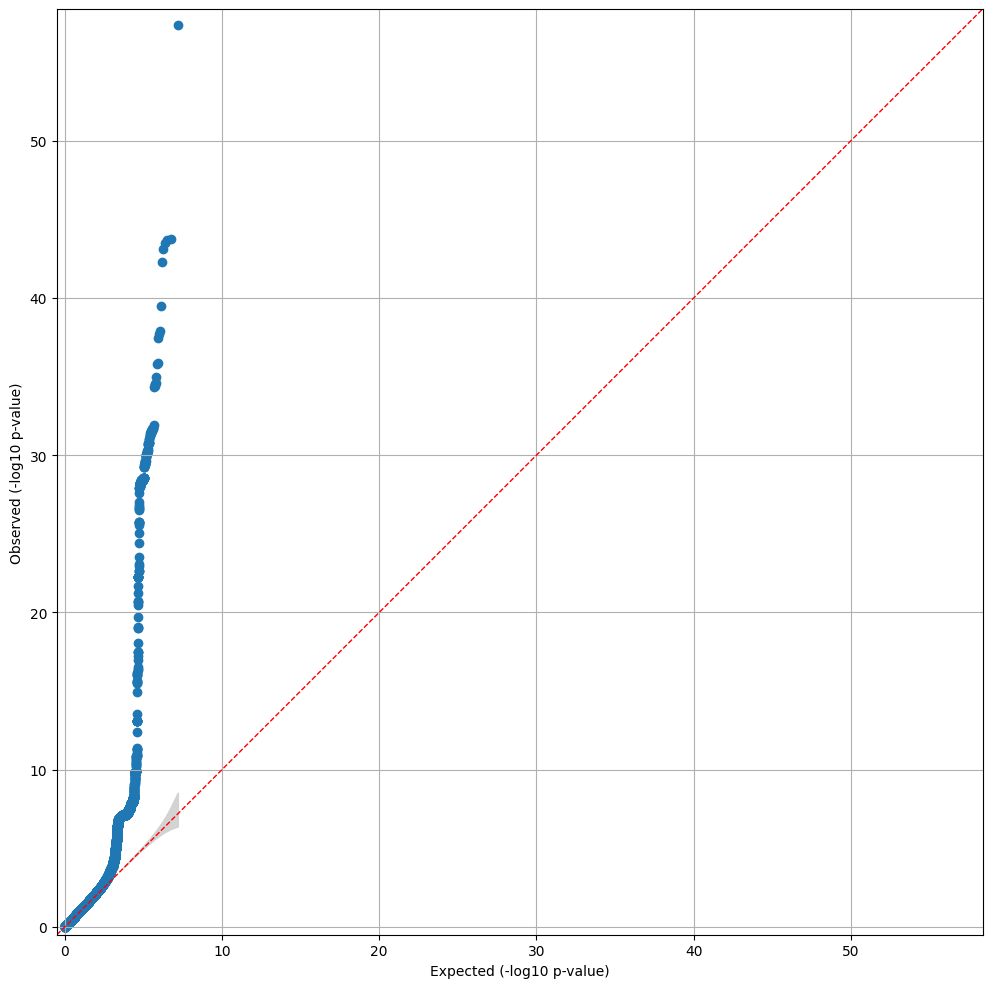

In [8]:
gwas_r_steps = {
    'preparatory': gwas_r.prepare_aux_files,
    'grm'        : gwas_r.compute_grm,
    'random'     : gwas_r.run_gwas_random,
    'top_hits'   : gwas_r.get_top_hits,
    'annotate'   : gwas_r.annotate_top_hits,
    'plots'      : gwas_r.plot_drawings
}
for step in gwas_r_steps.keys():
    gwas_r_steps[step]()

In [35]:
import pandas as pd

df_gwas_top = pd.read_csv('/home/luis/data/MiamiPlots/lux_data_hg19.txt', sep='\t', usecols=['CHROM', 'POS', 'P', 'ID'], low_memory=False)
df_gwas_top = df_gwas_top[~((df_gwas_top['CHROM']=='Y') | (df_gwas_top['CHROM']=='X'))].reset_index(drop=True)
df_gwas_top['CHROM'] = df_gwas_top['CHROM'].astype(int)
df_gwas_top.columns = ['CHR', 'bp', 'SNP', 'p']
df_gwas_top.to_csv('/home/luis/data/MiamiPlots/luxgiant_data_hg19.txt', sep='\t', index=False)


In [36]:
df_gwas_bottom = pd.read_csv('/home/luis/data/MiamiPlots/nallsEtAl2019_excluding23andMe_allVariants.tab', sep='\t',usecols=['SNP', 'p'], low_memory=False)
df_gwas_bottom['CHR'] = df_gwas_bottom['SNP'].apply(lambda x: int(x.split(':')[0][3:]))
df_gwas_bottom['bp'] = df_gwas_bottom['SNP'].apply(lambda x: int(x.split(':')[1]))
df_gwas_bottom.to_csv('/home/luis/data/MiamiPlots/known_results_hg19.txt', sep='\t', index=False)

In [1]:
from luxgiant_dstream import plots
import pandas as pd

In [2]:
df_gwas_top = pd.read_csv('/home/luis/data/MiamiPlots/luxgiant_data_hg19.txt', sep='\t')
df_gwas_bottom = pd.read_csv('/home/luis/data/MiamiPlots/known_results_hg19.txt', sep='\t')

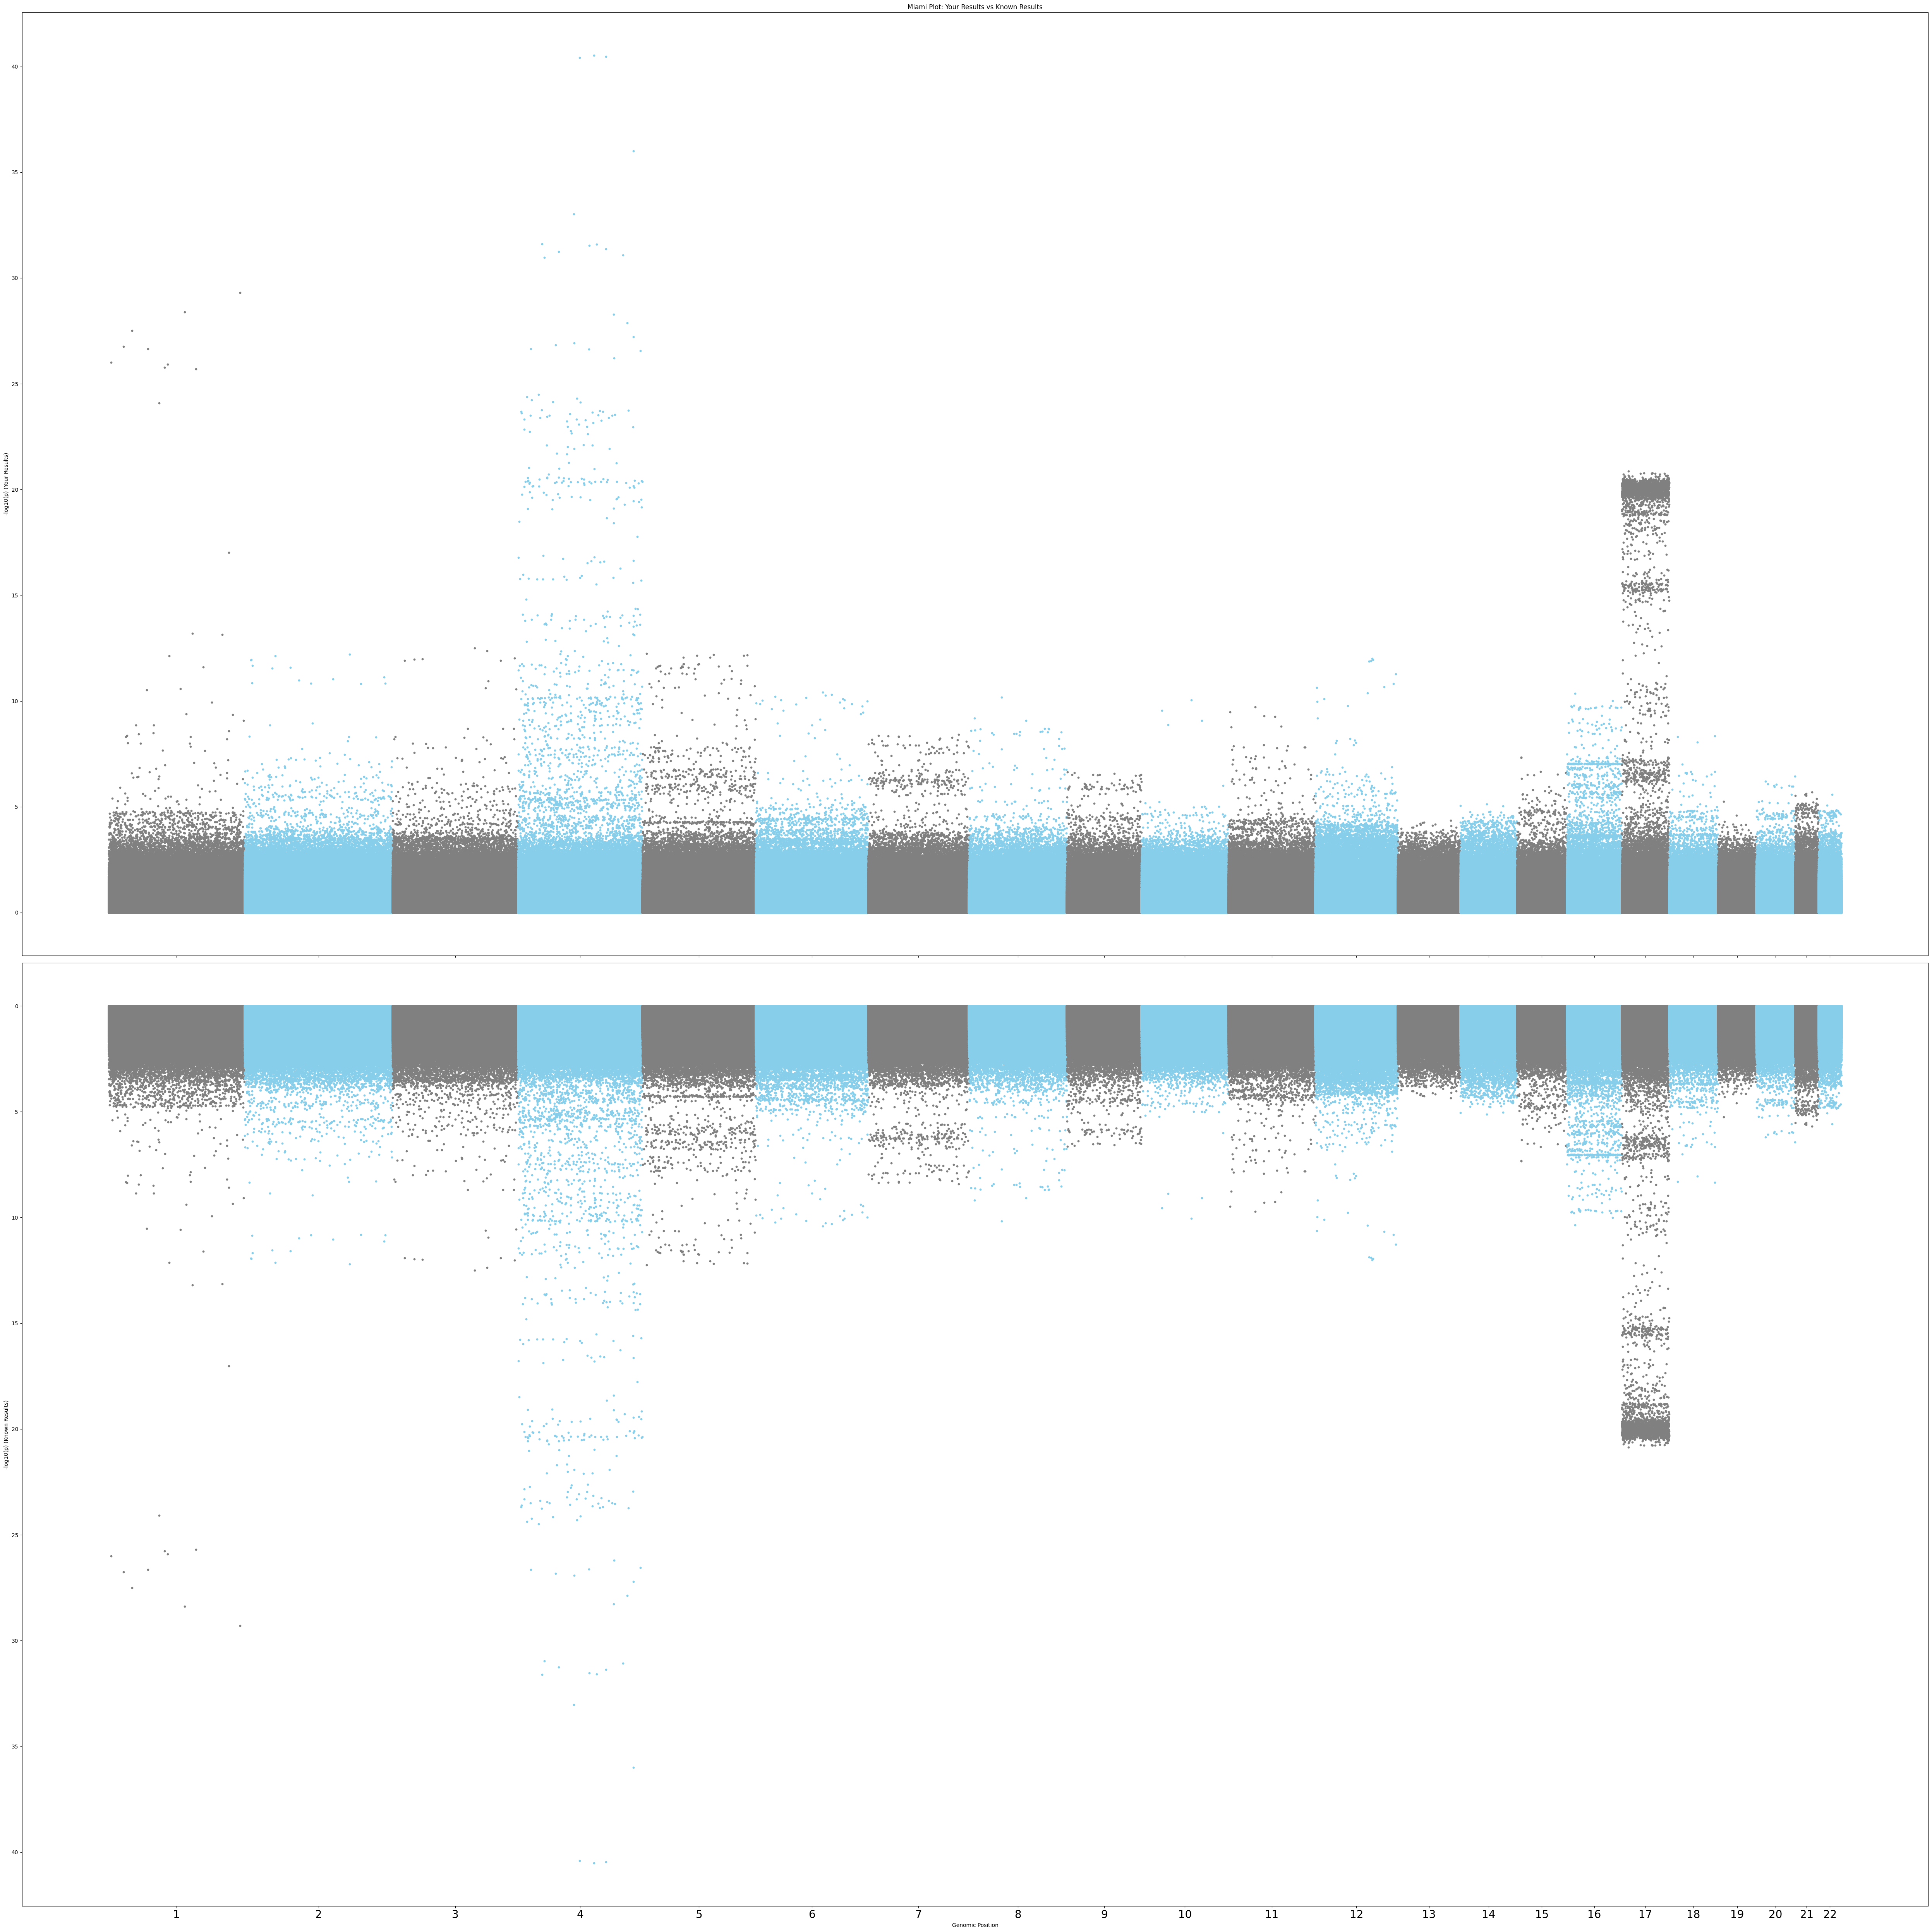

In [5]:
plots.miami_plot(
    df_gwas_top=df_gwas_bottom,
    df_gwas_bottom=df_gwas_bottom,
    plots_dir='/home/luis/data/MiamiPlots',
)

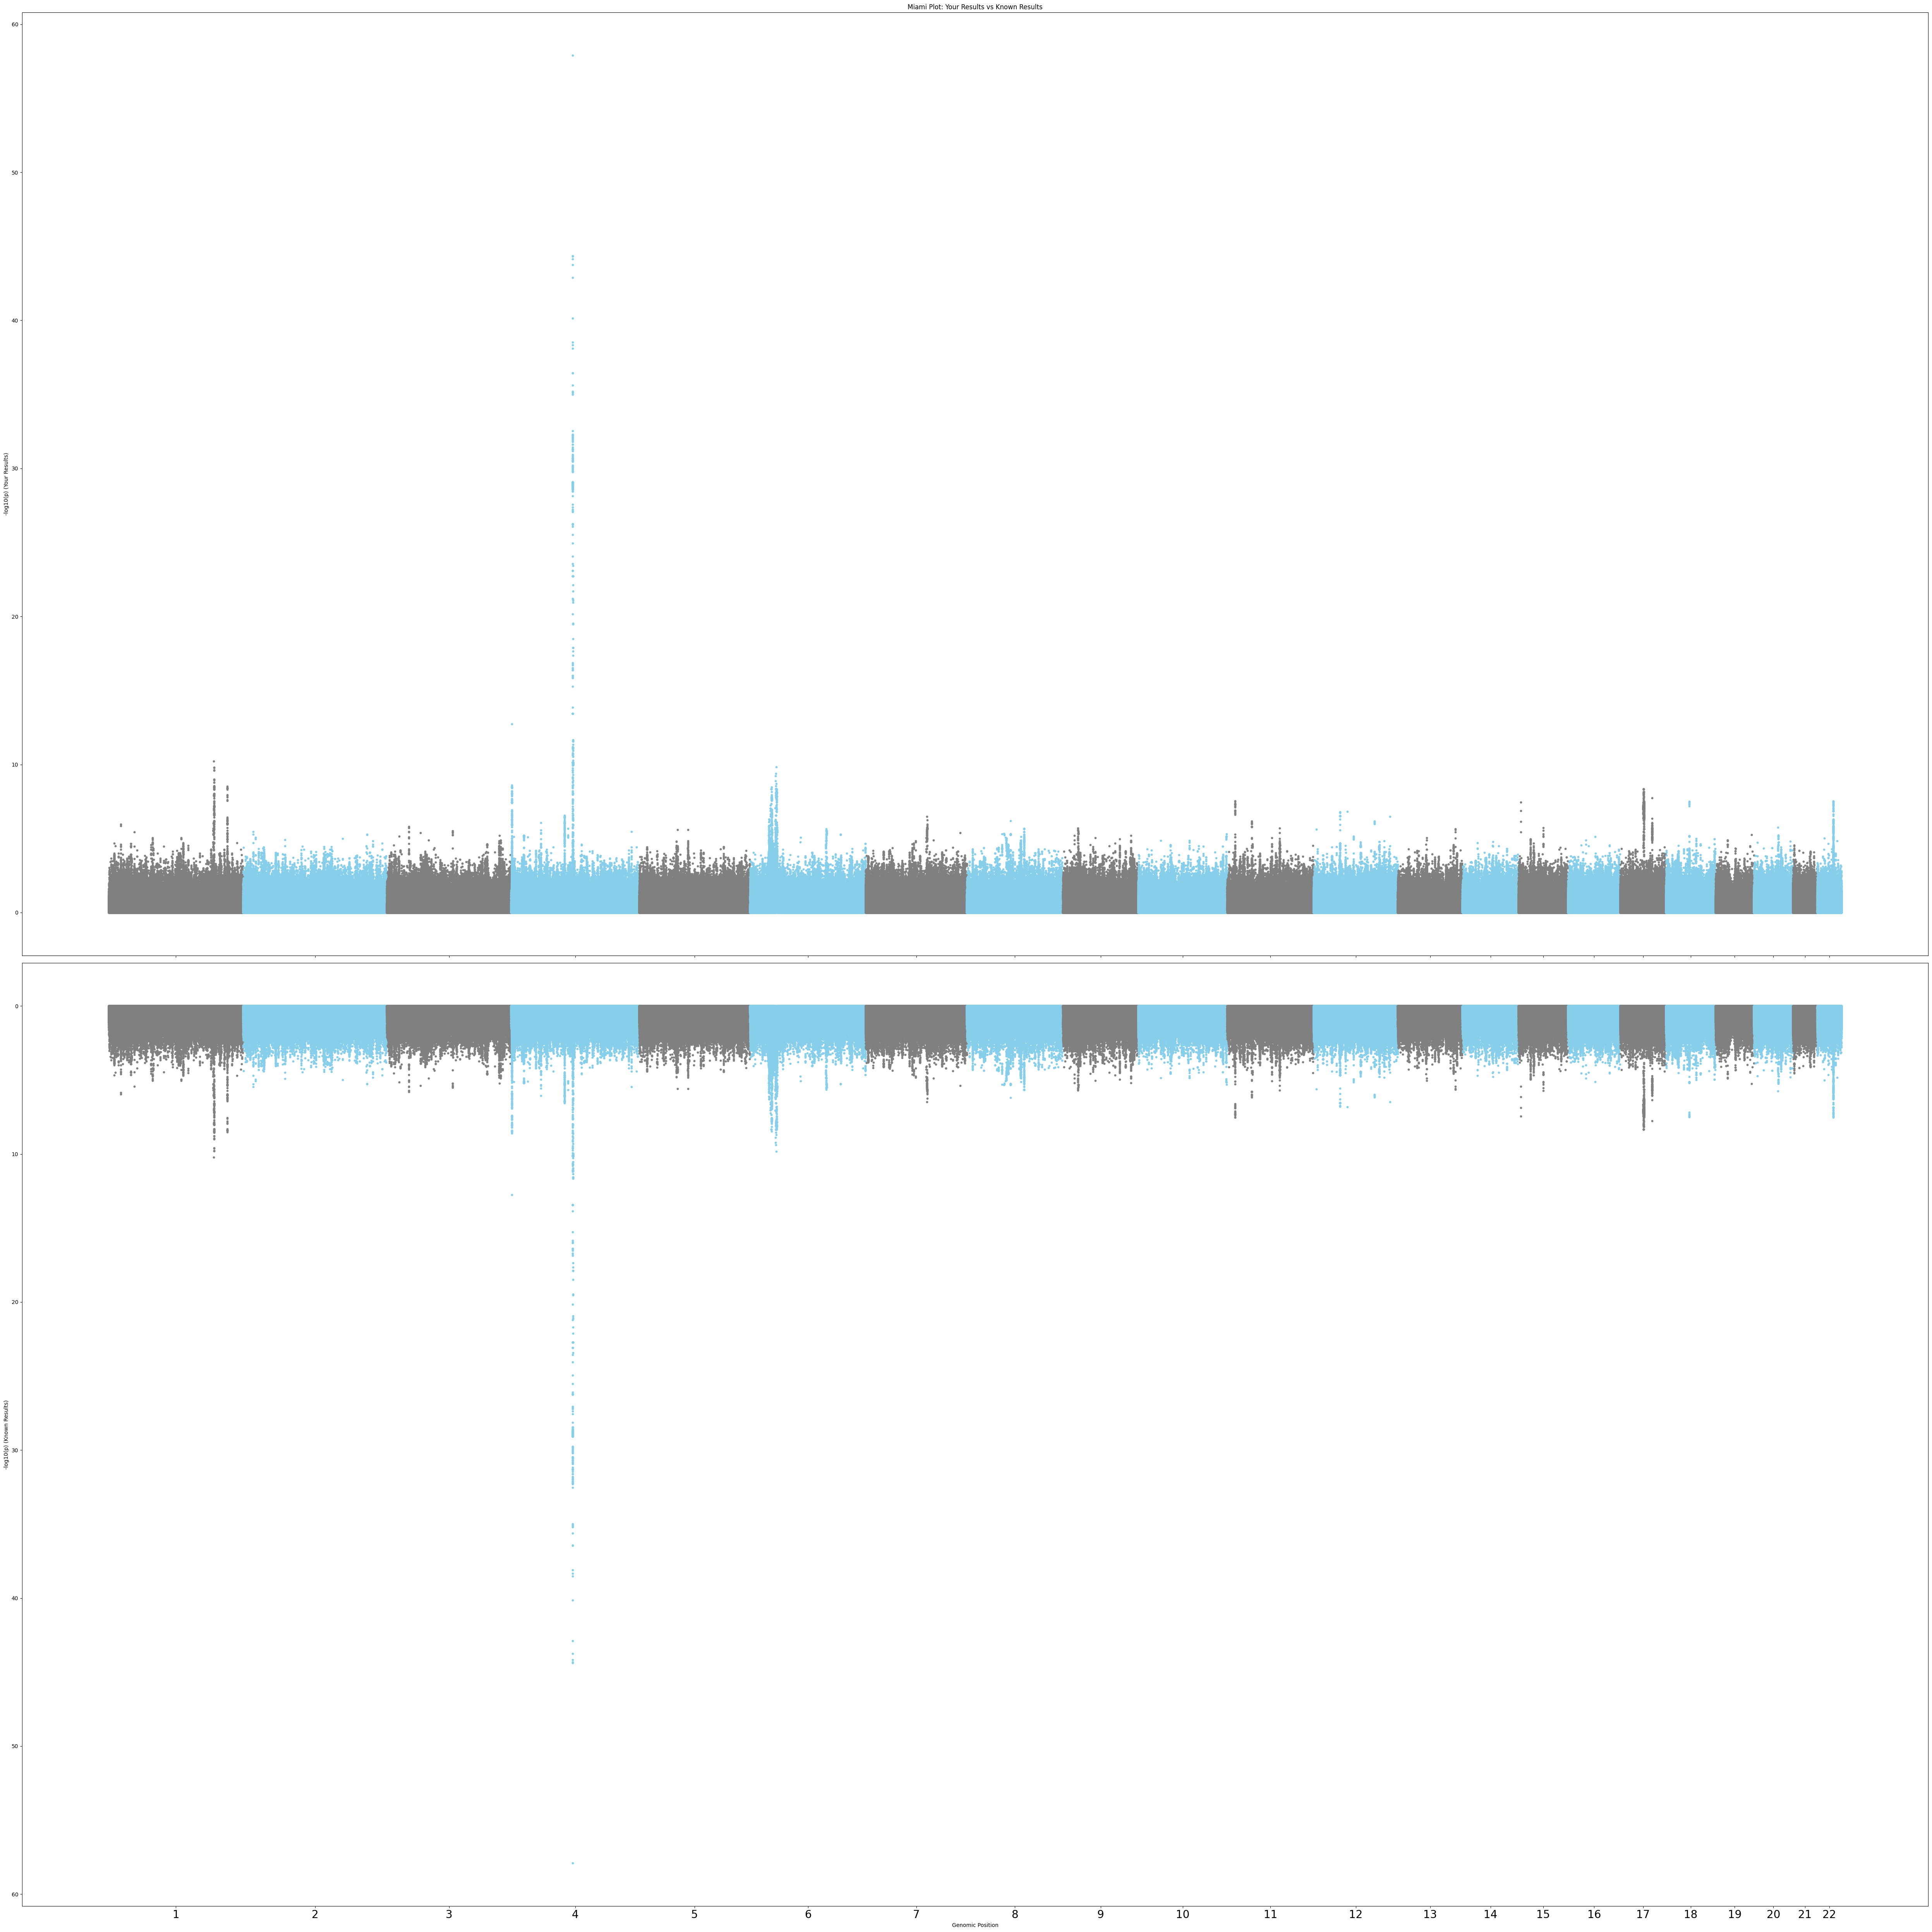

In [6]:
plots.miami_plot(
    df_gwas_top=df_gwas_top,
    df_gwas_bottom=df_gwas_top,
    plots_dir='/home/luis/data/MiamiPlots',
)